## Validation analysis against open/closed cells
---------------
This notebook focuses on the validation analysis, which includes inference of trained model with lablled input data and clustering against the output of model.

-----------
### Recap: Definition of open/closed cells
we ONLY need CLEAR open and closed cells s.t. very simillar to following pictures.  
Other than these figures, we DONOT NEED them (Or, peripheral/boundary patches of these clear ones are nice to save for following analysis)

#### Open cell
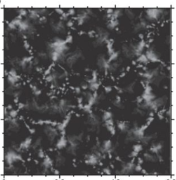
![Open]("./img/open.PNG")

##### Closed cell
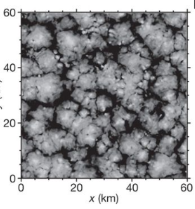
![Closed]("./img/closed.PNG")


---------------
### Prerequisites
Libraries below are necessary to download on you laptop (If disk amount is issue, we can move to Midway cluster-computer where the analysis is much easier if you have already got the access)

1. Tensorflow 1.12.0 for CPU [stackoverflow How to install CPU version of Tnesorflow](https://stackoverflow.com/questions/53614262/how-to-install-cpu-version-of-tensorflow-using-conda)
2. PySpark [pyspark](https://pypi.org/project/pyspark/)

--------------
### Load module

In [784]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
#import matplotlib.pyplot as plt
#from matplotlib import patches as mpl_patches
import itertools
import pandas as pd
#import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

# pyspark libs
#import pyspark
#from pyspark import SparkContext 
#from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel


In [785]:
## directory where your put lib_hdfs
libdir='/home/rubywerman/scratch-midway2/lib_hdfs'

In [786]:
sys.path.insert(1,os.path.join(sys.path[0],libdir)) # this line helps you to use your own functions in another directory
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array
%reload_ext autoreload
%autoreload 2
from pyhdf.SD import SD, SDC

### Load Model

In [787]:
homedir = libdir
datadir = homedir+"/model/m2_02_global_2000_2018_band28_29_31"
step = 100000 # DONOT change so far

In [788]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

/home/rubywerman/.conda/envs/clouds/lib/python3.6/site-packages/tensorflow/python/keras/layers/core.py:891: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Load labelled open/closed cell
Tasks
1. Combine your open-notebook contents here

In [789]:
# enter name of text file containing the dates of the closed patches
closed_file_name = "/home/rubywerman/clouds/src_analysis/close_cells_mod02/close_dates_1.txt"
closed_text_file = open(closed_file_name, "r")
closed_dates = closed_text_file.read().split('\n')

# enter name of text file containing the dates of the open patches
open_file_name = "/home/rubywerman/clouds/src_analysis/open_cells_mod02/open_dates_1.txt"
open_text_file = open(open_file_name, "r")
open_dates = open_text_file.read().split('\n')

In [790]:
#select directory path for given date
def get_data(d):
    return (homedir+'/mod02/open_chile_3/' + d, homedir+'/mod35/open_chile_3/' + d, get_coded_date(d))

### Run Analysis
we will use a type of hierarchical clusering called `bisecting-kmeans` [pyspark bisecting-kmeans](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#bisecting-k-means) .   

* In the case...  
If anything trouble happened, you may use another hierarchical clustering called `Agglometative clustering` . How to donwload agglomerative [sklearn aggl](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)  

`from sklearn.cluster import AgglomerativeClustering`

In [791]:
class Patch:        
    def __init__(self, date, isOpen, thirtyFive, zeroTwo, label=None, feature=None, has_coord=False, coords=None):
        self.date = date
        self.isOpen = isOpen
        self.thirtyFive = thirtyFive
        self.zeroTwo = zeroTwo
        self.label = label
        self.feature = feature
        self.has_coord = has_coord
        self.coords = coords
        
    def print_attr(self):
        print("date: " + self.date)
        print("isOpen: " + str(self.isOpen))
        print("label: " + str(self.label))
        if len(self.coords) > 0:
            print("coords: ")
            for i in self.coords:
                print(str(i))
        
        
class Cluster:
    def __init__(self, label, patches=None, means=None, std=None, num_open=0):
        self.label = label
        self.patches = patches
        self.means = means
        self.std = std
        self.num_open = num_open

        
#generates list of 6 means for each band in the patch list 
def get_band_means(patch_list):
    mean_list = []
    for i in range(6):
        mean_list.append(np.nanmean([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return mean_list

#generates list of 6 stds for each band in the patch list 
def get_band_std(patch_list):
    std_list = []
    for i in range(6):
        std_list.append(np.nanstd([patch.zeroTwo[0,0,:,:,:][:,:,i] for patch in patch_list]))
    return std_list

In [792]:
#collect close patch 35 and 02 data
closed_patch_class_list = []
for d in closed_dates:
    if d:
        file_name_a = '/home/rubywerman/clouds/src_analysis/close_cells_mod02/closed_'+ d +'.npy'
        #closed_date_data = np.load(file_name_a[:72] + file_name_a[-4:])
        closed_date_data = np.load(file_name_a)
        file_name_b = '/home/rubywerman/clouds/src_analysis/close_cells_coords/closed_coords'+ d +'.npy'
        if os.path.exists(file_name_b[:79] + file_name_b[-4:]):
            coords = np.load(file_name_b[:79] + file_name_b[-4:])
        else:
            coords = 6
        if os.path.exists('/home/rubywerman/clouds/src_analysis/close_35/close_35_'+ d +'.npy'): 
            thirtyFive = np.load('/home/rubywerman/clouds/src_analysis/close_35/close_35_'+ d +'.npy')
        else:
            thirtyFive = 6
        for patch in range(len(closed_date_data)):
            if type(thirtyFive) is not int and type(coords) is not int:
                closed_patch_class_list.append(Patch(date=d, isOpen=False, thirtyFive=thirtyFive, zeroTwo=closed_date_data[patch], label=None, feature=None, has_coord=True, coords=coords[patch]))
            else:
                closed_patch_class_list.append(Patch(date=d, isOpen=False, thirtyFive=None, zeroTwo=closed_date_data[patch], label=None, feature=None, has_coord=False, coords=None))


In [793]:
#collect open patch 35 and 02 data
open_patch_class_list = []
for d in open_dates:
    if d:
        file_name_a = '/home/rubywerman/clouds/src_analysis/open_cells_mod02/open_'+ d +'.npy'
        #open_date_data = np.load(file_name_a[:69] + file_name_a[-4:])
        open_date_data = np.load(file_name_a)
        file_name_b = '/home/rubywerman/clouds/src_analysis/open_cells_coords/open_coords'+ d +'.npy'
        if os.path.exists(file_name_b[:76] + file_name_b[-4:]):
            coords = np.load(file_name_b[:76] + file_name_b[-4:])
        else: 
            coords = 2
        if os.path.exists('/home/rubywerman/clouds/src_analysis/open_35/open_35_'+ d +'.npy'):
            thirtyFive = np.load('/home/rubywerman/clouds/src_analysis/open_35/open_35_'+ d +'.npy')
        else: 
            thirtyFive = 2
        for patch in range(len(open_date_data)):
            if type(thirtyFive) is not int and type(coords) is not int:
                open_patch_class_list.append(Patch(date=d, isOpen=True, thirtyFive=thirtyFive, zeroTwo=open_date_data[patch], label=None, feature=None, has_coord=True, coords=coords[patch]))
            else:
                open_patch_class_list.append(Patch(date=d, isOpen=True, thirtyFive=None, zeroTwo=open_date_data[patch], label=None, feature=None, has_coord=False, coords=None))


below you may create a list of patches of both open and closed patches.
you have to save where/which patches are labelled as open/closed cell.

In [794]:
# here make patches list
class_patch_list = open_patch_class_list + closed_patch_class_list

In [795]:
print("Number of patches recorded: " + str(len(class_patch_list)))

Number of patches recorded: 84


###### Inference

In [796]:
encs_list = []
for patch in class_patch_list:
    i = patch.zeroTwo
    if type(i) is not list:
        ix, iy = i.shape[:2]
        encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
        encs_list += [encs.mean(axis=(1,2))]

In [797]:
features = np.concatenate(encs_list, axis=0)

In [798]:
print(features.shape)  # make sure, the shape is [#number of patches, 128]

(84, 128)


##### Clustering

In [799]:
#the first %num_open_features rows in features are open cells 
num_open_features = len(open_patch_class_list)
#starting at row %num_open_features in features they are closed cells 
num_closed_features = len(closed_patch_class_list)

In [800]:
from sklearn.cluster import AgglomerativeClustering

In [812]:
# N in [2, inf), you can change this number but save the result differently
num_clusters = 8

In [813]:
clustering = AgglomerativeClustering(num_clusters)

In [814]:
#turns any NAN values to 0 so code doesn't crash
cleaned_features = np.nan_to_num(features)

In [815]:
#generate clustering data
label = clustering.fit_predict(cleaned_features)
open_labels = label[:num_closed_features]
closed_labels = label[num_closed_features:]

In [816]:
#assign each patch instance its correct label
for i in range(len(class_patch_list)):
    class_patch_list[i].label = label[i]

In [817]:
#make a list of clusters
list_clusters = [Cluster(label=i) for i in range(num_clusters)]

In [818]:
#add patches to cluster objects
for p in class_patch_list:
    matching_cluster = list_clusters[p.label]
    if p.isOpen:
        matching_cluster.num_open += 1
    if not matching_cluster.patches:
        matching_cluster.patches = [p]
    else:
        matching_cluster.patches.append(p)

In [819]:
#add patch mean and std to cluster objects
for c in list_clusters:
    c.means = get_band_means(c.patches)
    c.std = get_band_std(c.patches)

## Visualize clustering accuracy

Visuallise how open and closed clusteres are differently classified

In [820]:
#create stacked bar graph 
def make_bar():
    from matplotlib import rc
    import pandas as pd

    plt.figure(figsize=(50,20))

    # Heights of bars
    bars = [len(open_clusters), len(closed_clusters)]

    # The position of the bars on the x-axis
    r = range(num_clusters)

    # Label for each bar and bar width
    x_labels = [str(i) for i in r]
    barWidth = .8

    # Create open-classified bars
    plt.bar(r, open_clusters, color='orange', width=barWidth)

    # Stack bars
    plt.bar(r, closed_clusters, bottom=open_clusters, color='blue', width=barWidth)

    # label/title graph
    plt.xticks(r, x_labels, fontsize=40)
    plt.yticks(fontsize=40)
    plt.ylabel("Number of patches", fontsize=40)
    plt.xlabel("Cluster number in: "+ str(clustering), fontsize=40)
    plt.legend(loc="upper right")
    plt.legend(('open','closed'), fontsize=40)
    plt.title("Agglomerative Clustering with %s total patches"%(len(label)), fontsize=40)
    plt.gcf().subplots_adjust(bottom=0.25)
    # Show graphic
    plt.savefig('/home/rubywerman/cluster_plots/stacked_bar_graphs/%d_cluster_plot.png'%(num_clusters))

# Utility function to visualize the outputs of t-SNE 
#takes in x, a 2d numpy array containing the output of the t-SNE algorithm and label, the 1d numpy array containing the labels of the dataset
#creates scatterplot with as many unique colors as the number of clusters
#source: https://www.datacamp.com/community/tutorials/introduction-t-sne
def cloud_scatter(x, label, num_clusters):
    #make a color palette with seaborn
    num_colors = len(np.unique(label))
    palette = np.array(sns.color_palette("hls", num_colors))
    
    #make scatter plot
    f = plt.figure(figsize=(50,20))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=15, s=40, c=palette[label.astype(np.int)])
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []
    for i in range(num_colors):
        # Position of each label at median of data points.
        xtext, ytext = np.median(x[label == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=20)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        plt.title("Visualization of %d patches in %s clusters produced by t-SNE"%(len(label), num_clusters), fontsize=40)
        plt.gcf().subplots_adjust(bottom=0.25)
        #plt.savefig('/home/rubywerman/cluster_plots/tsne_plots/%d_tsne.png'%(num_clusters))
        # Show graphic
    return f, ax, sc, txts

#visualize t-SNE 
def make_tsne():
    from sklearn.manifold import TSNE
    cloud_tsne = TSNE().fit_transform(cleaned_features)
    plot = cloud_scatter(cloud_tsne, label)

def make_plots(num_cluster):
    # N in [2, inf), you can change this number but save the result differently
    num_clusters = num_cluster

    clustering = AgglomerativeClustering(num_clusters)

    #turns any NAN values to 0 so code doesn't crash
    cleaned_features = np.nan_to_num(features)

    #generate clustering data
    label = clustering.fit_predict(cleaned_features)
    open_labels = label[:num_closed_features]
    closed_labels = label[num_closed_features:]

    #assign each patch instance its correct label
    for i in range(len(class_patch_list)):
        class_patch_list[i].label = label[i]

    #make a list of clusters
    list_clusters = [Cluster(label=i) for i in range(num_clusters)]

    #add patches to cluster objects
    for p in class_patch_list:
        matching_cluster = list_clusters[p.label]
        if p.isOpen:
            matching_cluster.num_open += 1
        if not matching_cluster.patches:
            matching_cluster.patches = [p]
        else:
            matching_cluster.patches.append(p)

    #add patch mean and std to cluster objects
    for c in list_clusters:
        c.means = get_band_means(c.patches)
        c.std = get_band_std(c.patches)

    #generate number of open and closed patches in each cluster
    open_clusters = [i.num_open for i in list_clusters]
    closed_clusters = [len(i.patches) - i.num_open for i in list_clusters]
    
    #save and make stacked bar graph
    from matplotlib import rc
    import pandas as pd

    plt.figure(figsize=(50,20))

    # Heights of bars
    bars = [len(open_clusters), len(closed_clusters)]

    # The position of the bars on the x-axis
    r = range(num_clusters)

    # Label for each bar and bar width
    x_labels = [str(i) for i in r]
    barWidth = .8

    # Create open-classified bars
    plt.bar(r, open_clusters, color='orange', width=barWidth)

    # Stack bars
    plt.bar(r, closed_clusters, bottom=open_clusters, color='blue', width=barWidth)

    # label/title graph
    plt.xticks(r, x_labels, fontsize=20)
    plt.yticks(fontsize=40)
    plt.ylabel("Number of patches", fontsize=40)
    plt.xlabel("Cluster number in: "+ str(clustering), fontsize=40)
    plt.legend(loc="upper right")
    plt.legend(('open','closed'), fontsize=40)
    plt.title("Agglomerative Clustering with %s total patches"%(len(label)), fontsize=40)
    plt.gcf().subplots_adjust(bottom=0.25)
    # Show graphic
    #plt.savefig('/home/rubywerman/cluster_plots/stacked_bar_graphs/%d_cluster_plot.png'%(num_clusters))
    
    #save and make t-sne
    from sklearn.manifold import TSNE
    cloud_tsne = TSNE().fit_transform(cleaned_features)
    plot = cloud_scatter(cloud_tsne, label,num_clusters)

W0715 15:27:58.747374 140500909606720 legend.py:1282] No handles with labels found to put in legend.


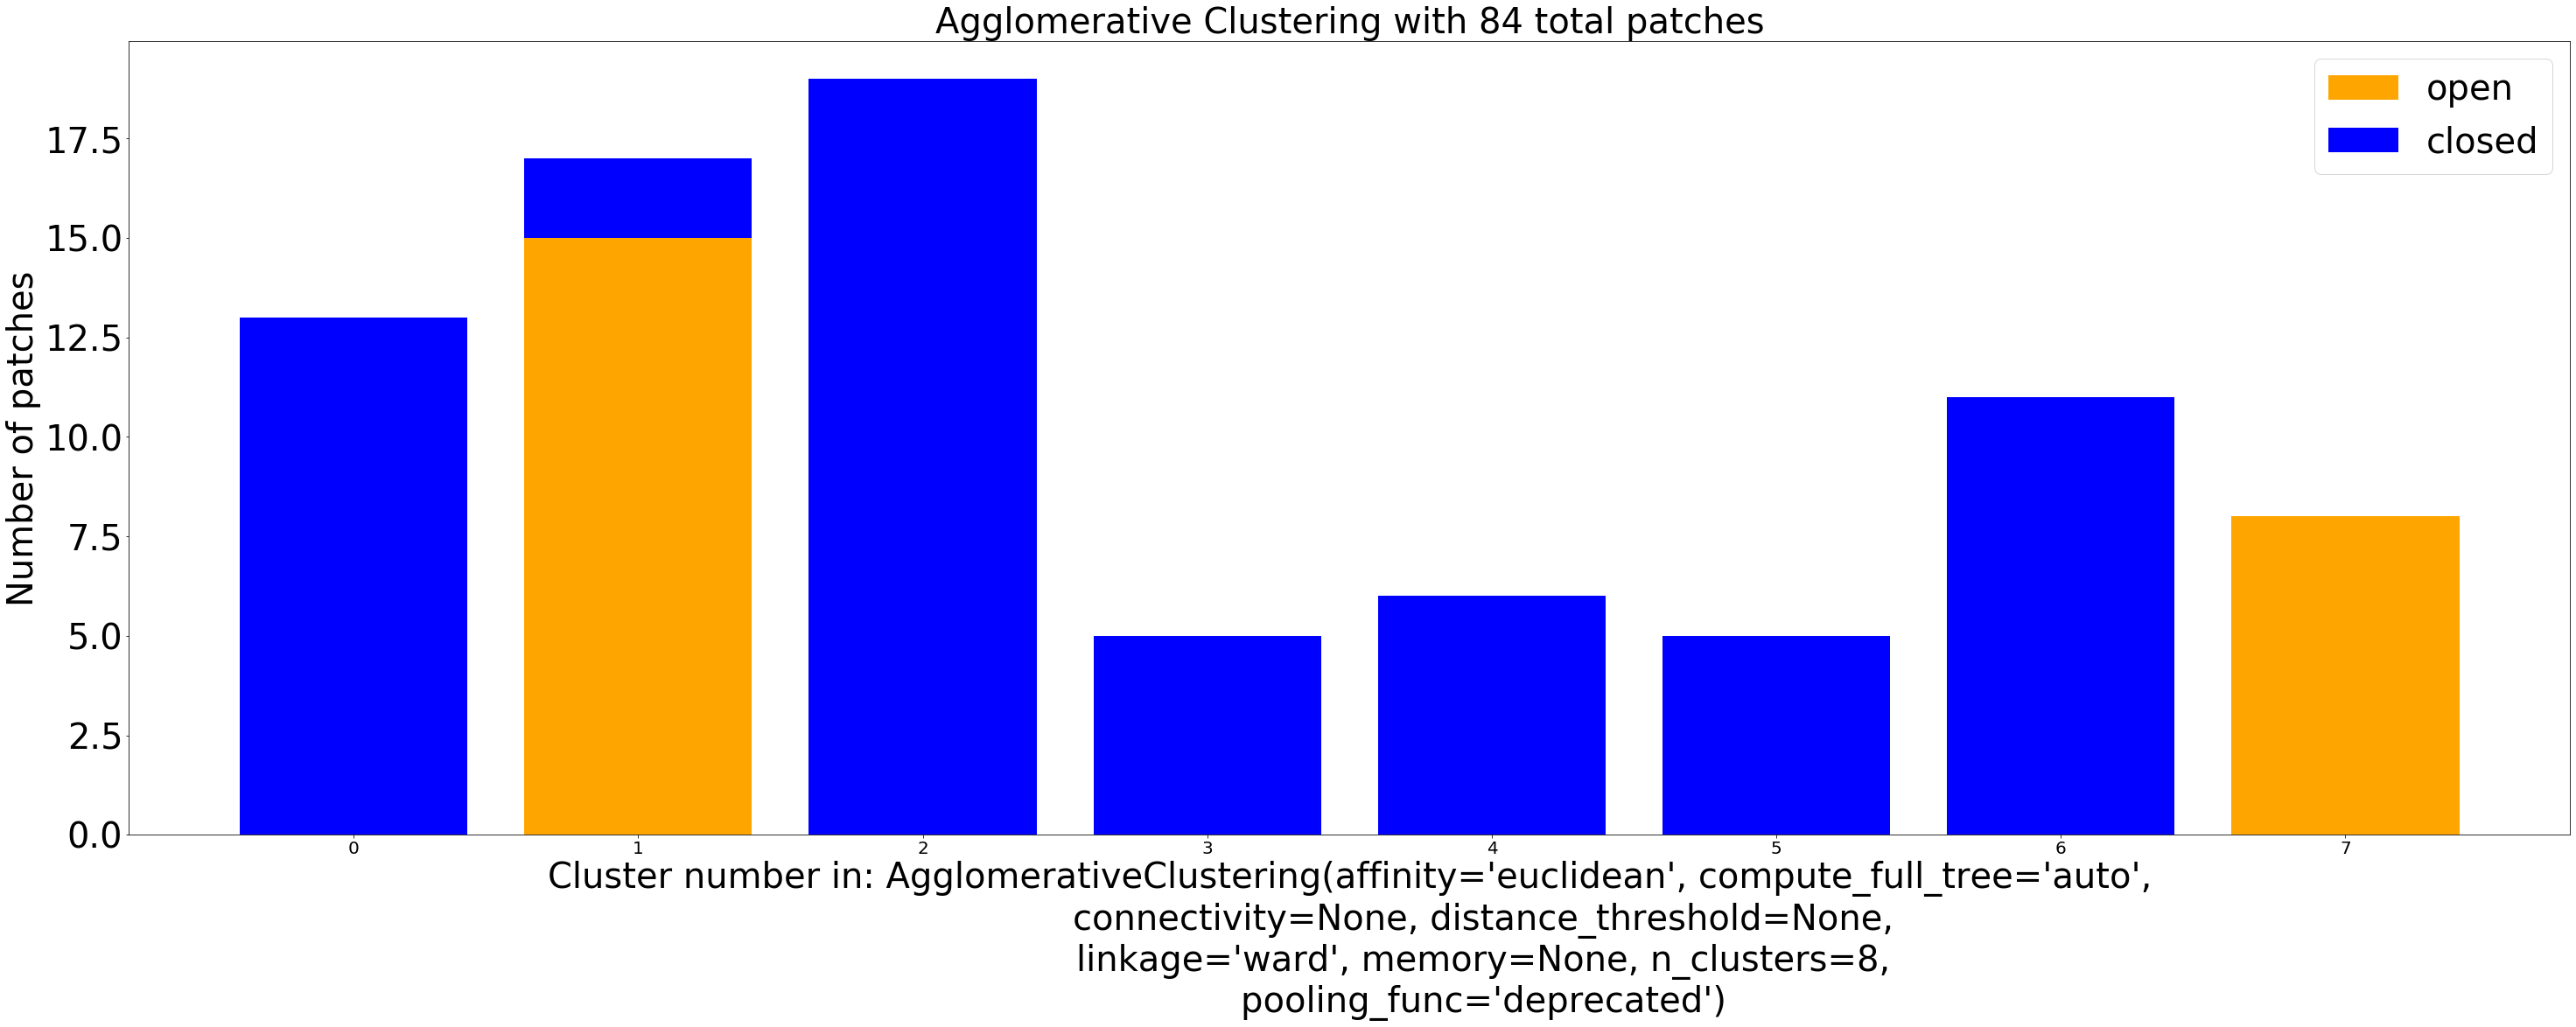

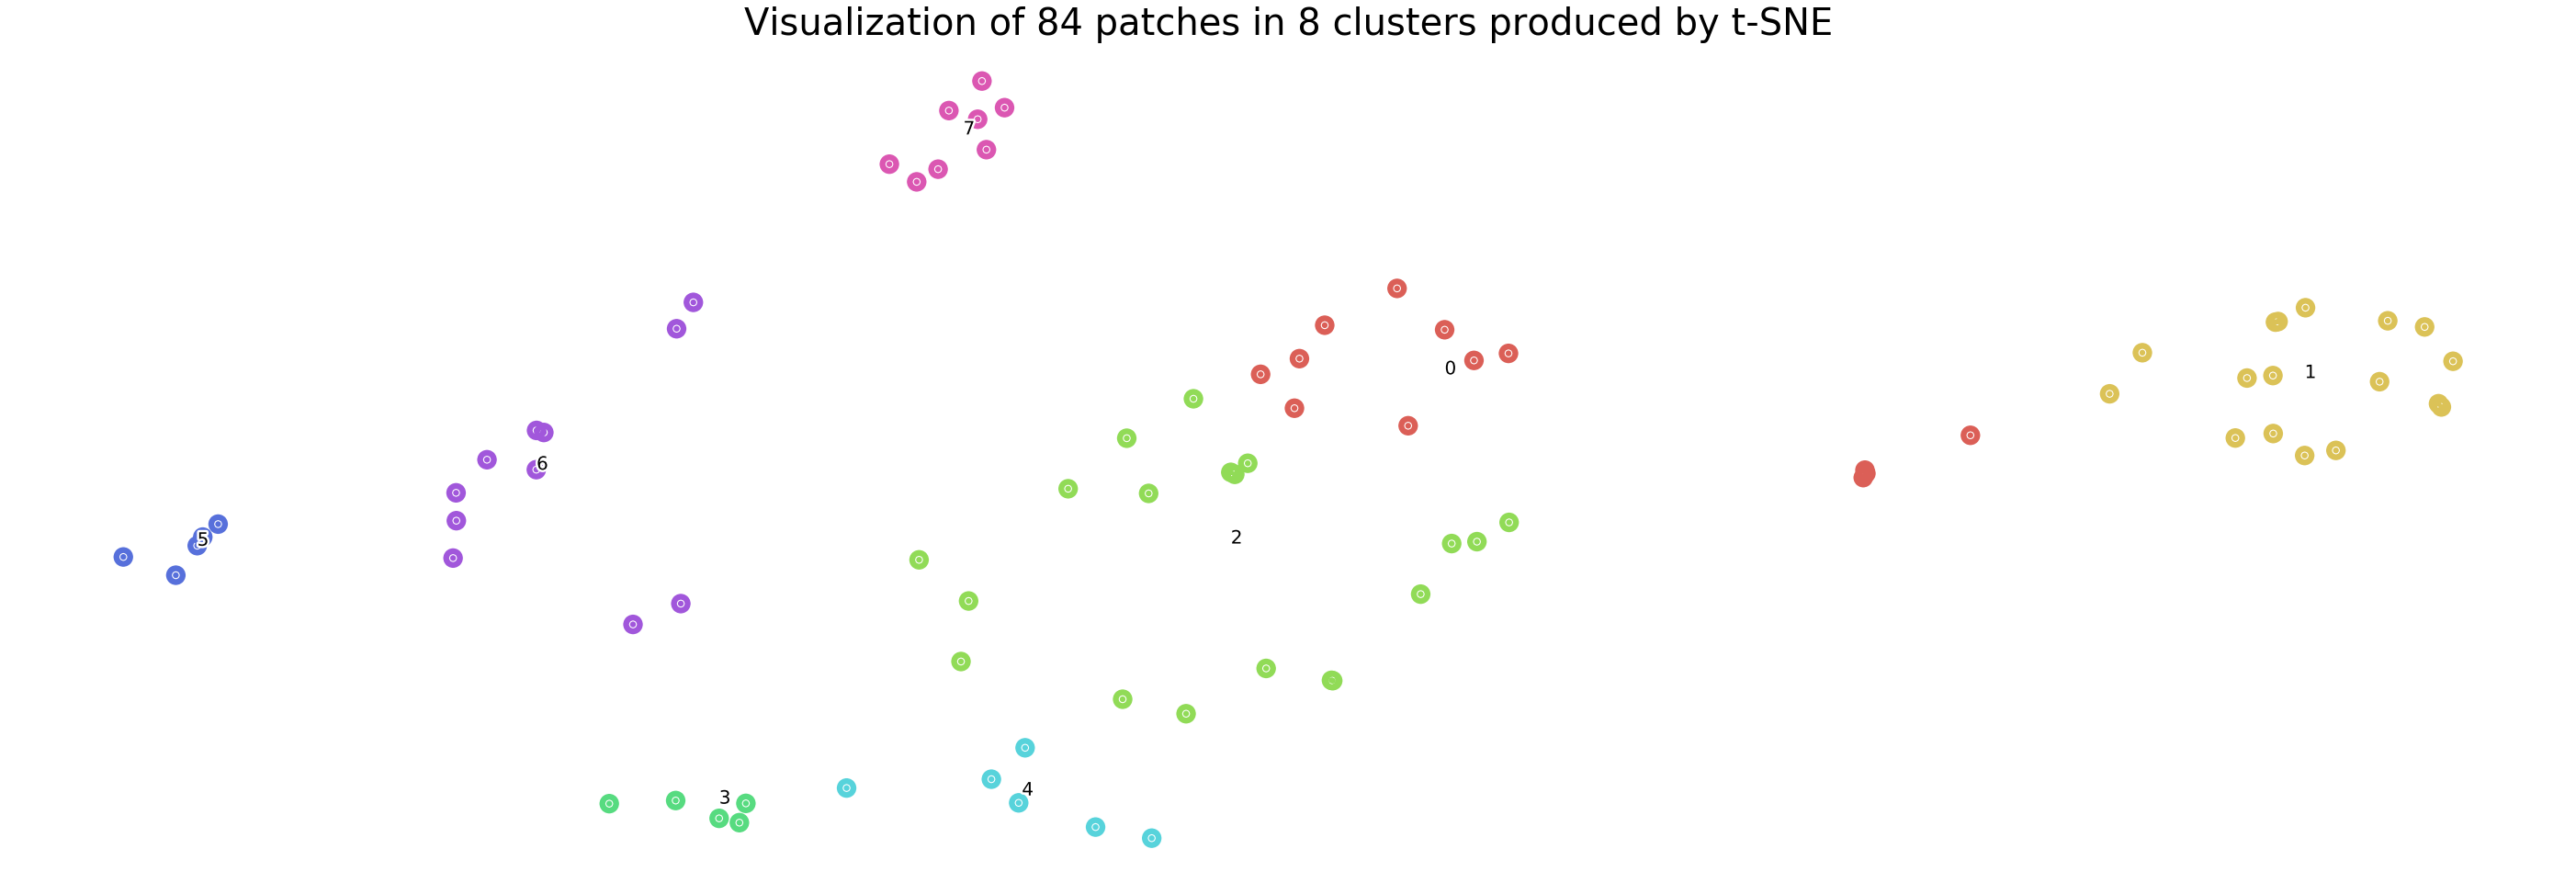

In [822]:
#for i in range(48, 102, 2):
  #  make_plots(i)
make_plots(num_clusters)

In [833]:
# cluster_labels = range(num_clusters)
open_list = [len(get_open_patches(i)) for i in range(num_clusters)]
closed_list = [len(get_closed_patches(i)) for i in range(num_clusters)]
df1 = pd.DataFrame(list(zip(open_list, closed_list)), 
               columns =['open', 'closed']) 
df1["% open"] = (df1["open"] / (df1["open"] + df1["closed"]))*100
df1["% closed"] = (df1["closed"] / (df1["open"] + df1["closed"]))*100
df1

,open,closed,% open,% closed
0,0,13,0.000000,100.000000
1,15,2,88.235294,11.764706
2,0,19,0.000000,100.000000
3,0,5,0.000000,100.000000
4,0,6,0.000000,100.000000
5,0,5,0.000000,100.000000
6,0,11,0.000000,100.000000
7,8,0,100.000000,0.000000


### Inspect certain clusters

In [824]:
def get_open_patches(cluster_num):
    open_in_cluster = [patch for patch in list_clusters[cluster_num].patches if patch.isOpen]
    o_list_pics = []
    for i in range(len(open_in_cluster)):
        p = open_in_cluster[i]
        o_list_pics.append(p.thirtyFive[p.coords[0]*128:p.coords[1]*128,p.coords[2]*128:p.coords[3]*128])
    return o_list_pics

def get_closed_patches(cluster_num):
    closed_in_cluster = [patch for patch in list_clusters[cluster_num].patches if not patch.isOpen]
    c_list_pics = []
    for i in range(len(closed_in_cluster)):
        p = closed_in_cluster[i]
        c_list_pics.append(p.thirtyFive[p.coords[0]*128:p.coords[1]*128,p.coords[2]*128:p.coords[3]*128])
    return c_list_pics

no open clusters in 0
closed in 0: 


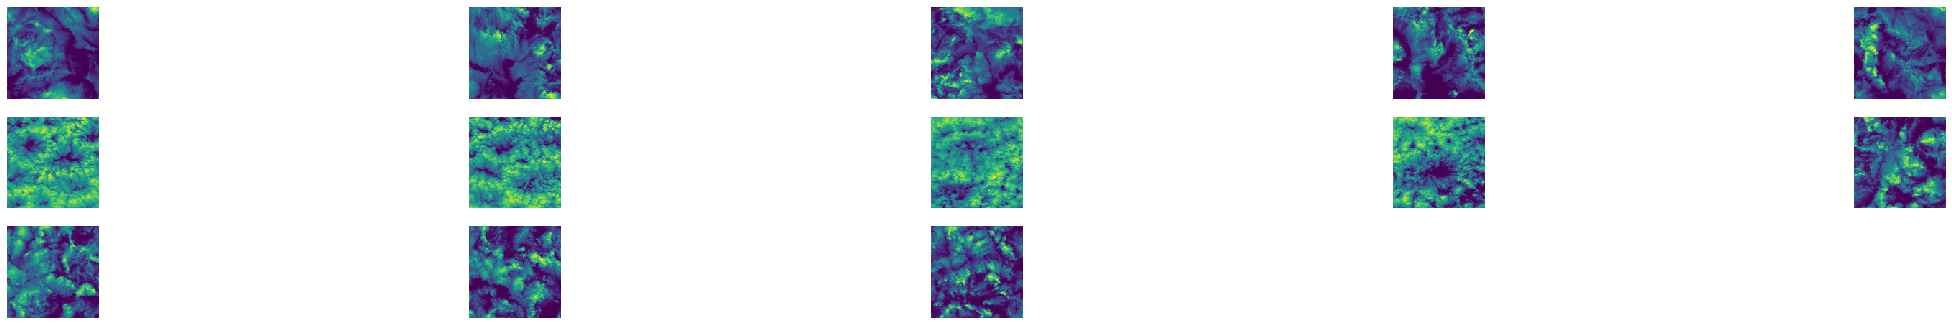

open in 1: 


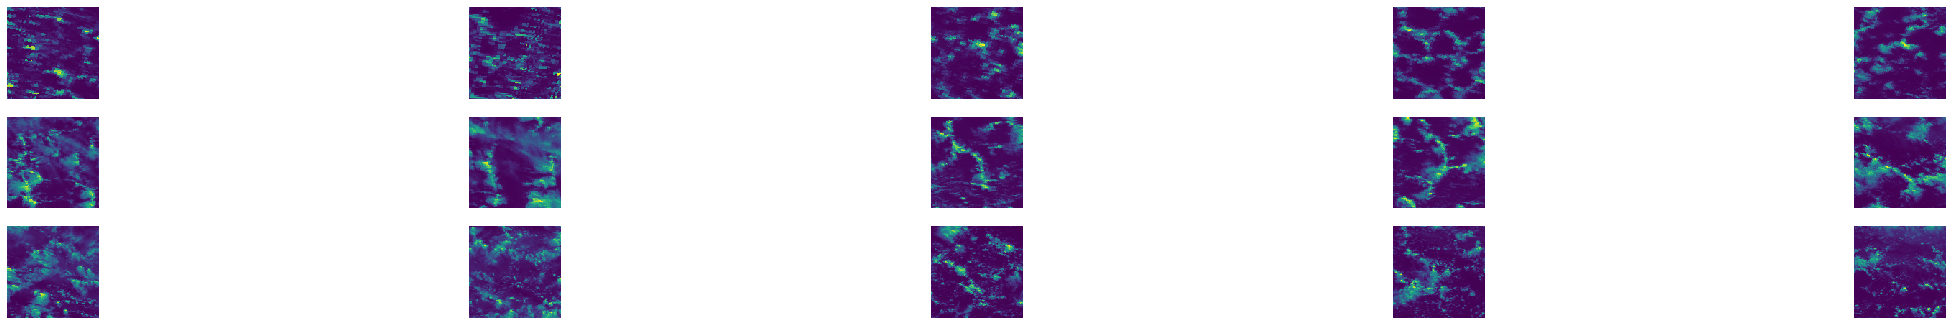

closed in 1: 


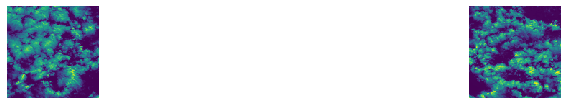

no open clusters in 2
closed in 2: 


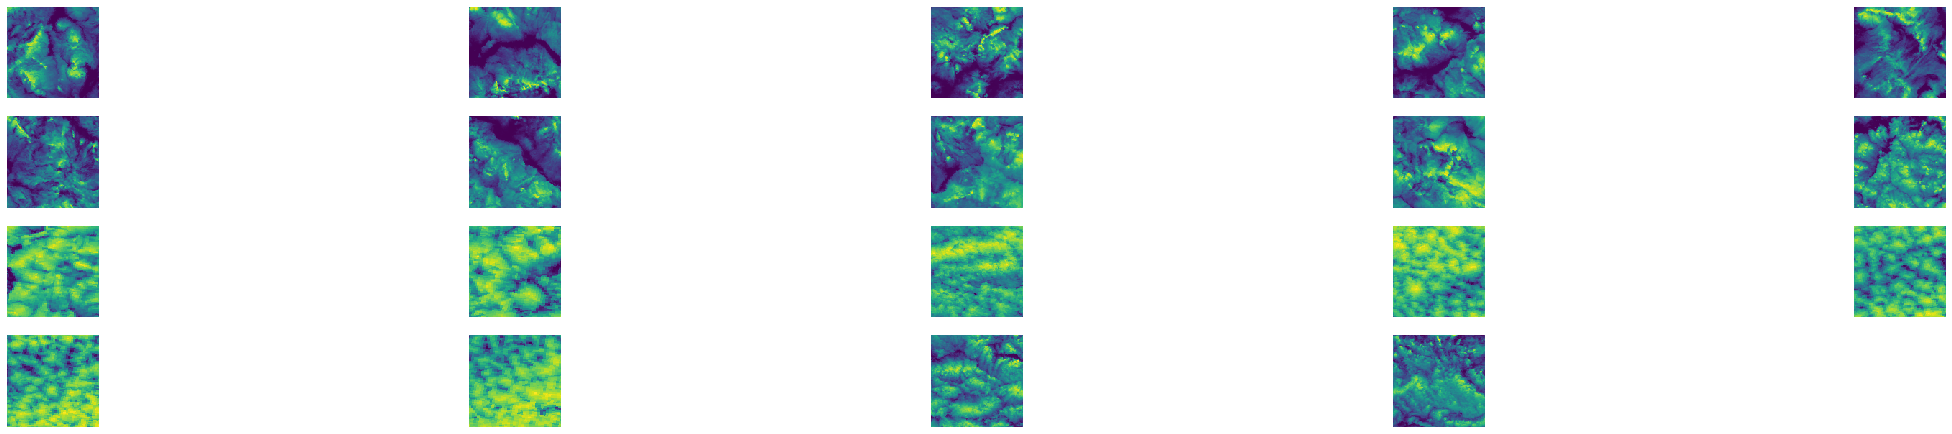

no open clusters in 3
closed in 3: 


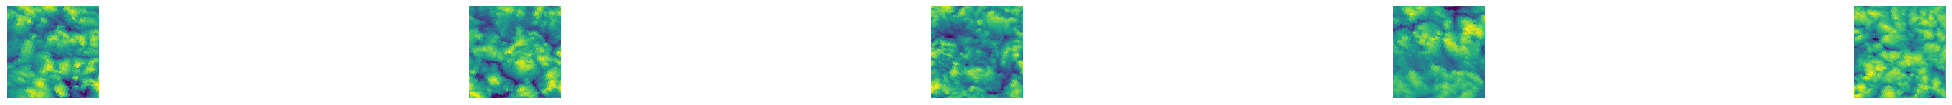

no open clusters in 4
closed in 4: 


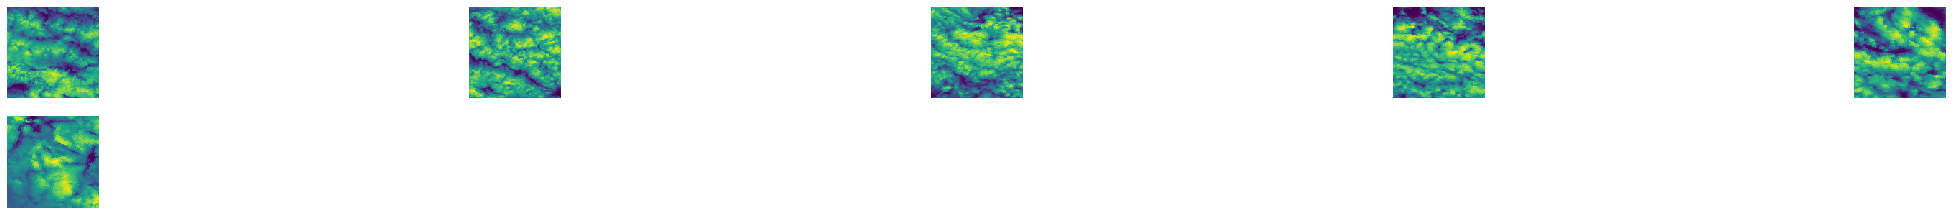

no open clusters in 5
closed in 5: 


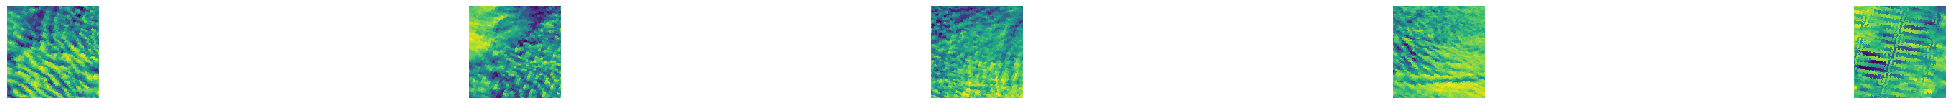

no open clusters in 6
closed in 6: 


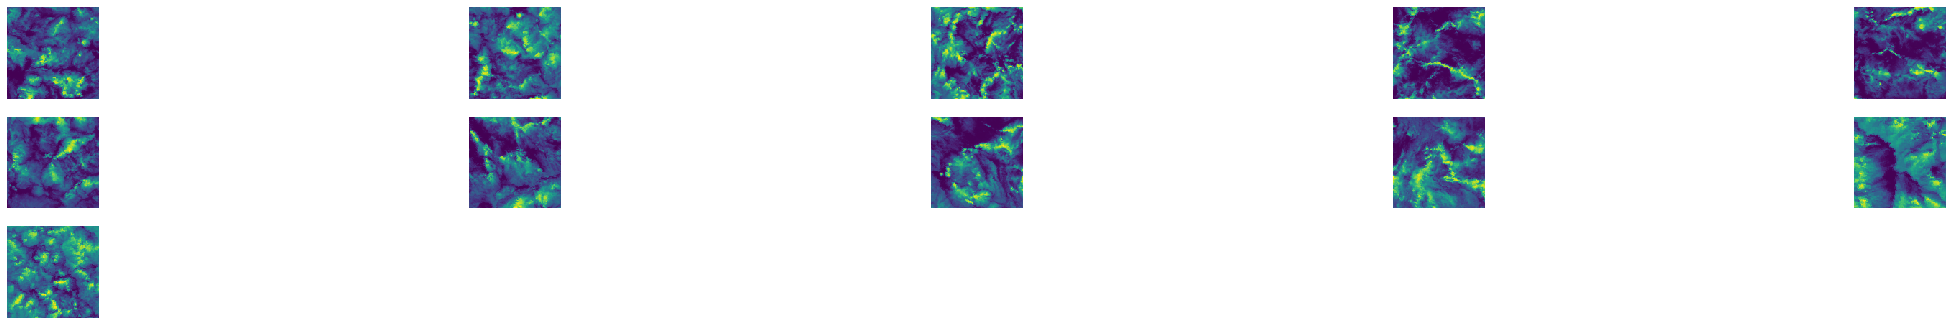

open in 7: 


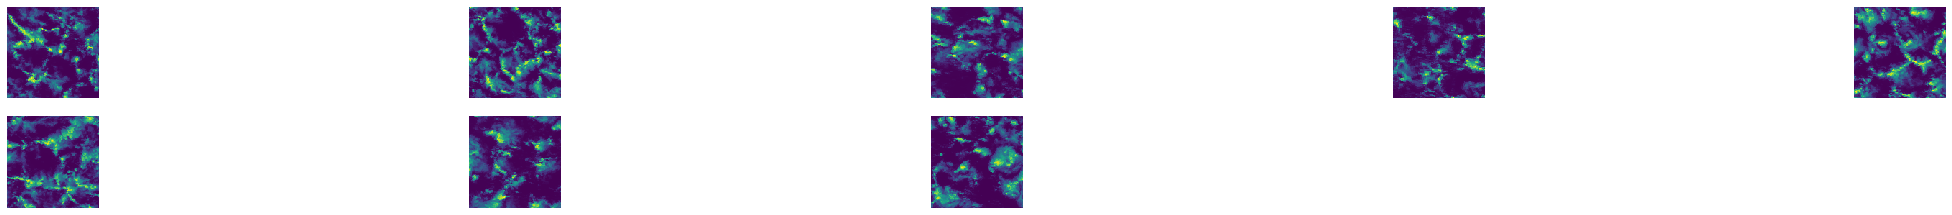

no closed clusters in 7


In [849]:
#displays open and closed patches for each cluster
for c in range(num_clusters):
    oo = get_open_patches(c)
    if len(oo) > 0:
        fig1=plt.figure(figsize=(40, 40))
        columns = 5
        rows = 20
        for i in range(1, len(oo) + 1):
            fig1.add_subplot(rows, columns, i)
            plt.imshow(oo[i-1])
            plt.axis('off')
        print("open in %d: "%(c))
        plt.show()
    else:
        print("no open clusters in %d"%(c))

    cc = get_closed_patches(c)
    if len(cc) > 0:
        fig2=plt.figure(figsize=(40, 40))
        for i in range(1, len(cc) + 1):
            fig2.add_subplot(rows, columns, i)
            plt.imshow(cc[i-1])
            plt.axis('off')
        print("closed in %d: "%(c))
        plt.show()
    else:
        print("no closed clusters in %d"%(c))

In [828]:
#removes desired patches from the cluster object's patch list
def remove_closed(cluster_num, indices):
    cluster = list_clusters[cluster_num]
    closed = [p for p in cluster.patches if not p.isOpen]
    to_save = [p for p in cluster.patches if p.isOpen]
    updated = to_save
    for i in range(len(closed)):
        if i not in indices:
            updated.append(cluster.patches[i])
    cluster.patches = updated
#removes desired patches from the cluster object's patch list
def remove_open(cluster_num, indices):
    cluster = list_clusters[cluster_num]
    to_save = [p for p in cluster.patches if not p.isOpen]
    openx = [p for p in cluster.patches if p.isOpen]
    updated = to_save
    for i in range(len(openx)):
        if i not in indices:
            updated.append(cluster.patches[i])
    cluster.patches = updated

In [ ]:
#overwrites data to get rid of bad patches, then 

In [ ]:
cleaned_patches = []
for c in list_clusters:
    cleaned_patches.extend(c.patches)
#overrite data to get rid of bad patches


# Visualize clustering on cleaned patches

In [830]:
encs_list1 = []
for patch in cleaned_patches:
    i = patch.zeroTwo
    if type(i) is not list:
        ix, iy = i.shape[:2]
        encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
        encs_list1 += [encs.mean(axis=(1,2))]

features1 = np.concatenate(encs_list1, axis=0)

print(features1.shape)  # make sure, the shape is [#number of patches, 128]

##### Clustering

#the first %num_open_features rows in features are open cells 

#starting at row %num_open_features in features they are closed cells 


from sklearn.cluster import AgglomerativeClustering

# N in [2, inf), you can change this number but save the result differently
num_clusters1 = num_clusters

clustering1 = AgglomerativeClustering(num_clusters1)

#turns any NAN values to 0 so code doesn't crash
cleaned_features1 = np.nan_to_num(features1)

#generate clustering data
label1 = clustering1.fit_predict(cleaned_features1)

#assign each patch instance its correct label
for i in range(len(cleaned_patches)):
    cleaned_patches[i].label = label1[i]

#make a list of clusters
list_clusters1 = [Cluster(label=i) for i in range(num_clusters1)]

#add patches to cluster objects
for p in cleaned_patches:
    matching_cluster1 = list_clusters1[p.label]
    if p.isOpen:
        matching_cluster1.num_open += 1
    if not matching_cluster1.patches:
        matching_cluster1.patches = [p]
    else:
        matching_cluster1.patches.append(p)

#add patch mean and std to cluster objects
for c in list_clusters1:
    c.means = get_band_means(c.patches)
    c.std = get_band_std(c.patches)

(35, 128)


In [831]:
open_clusters1 = [i.num_open for i in list_clusters1]
closed_clusters1 = [len(i.patches) - i.num_open for i in list_clusters1]

W0715 15:31:55.445592 140500909606720 legend.py:1282] No handles with labels found to put in legend.


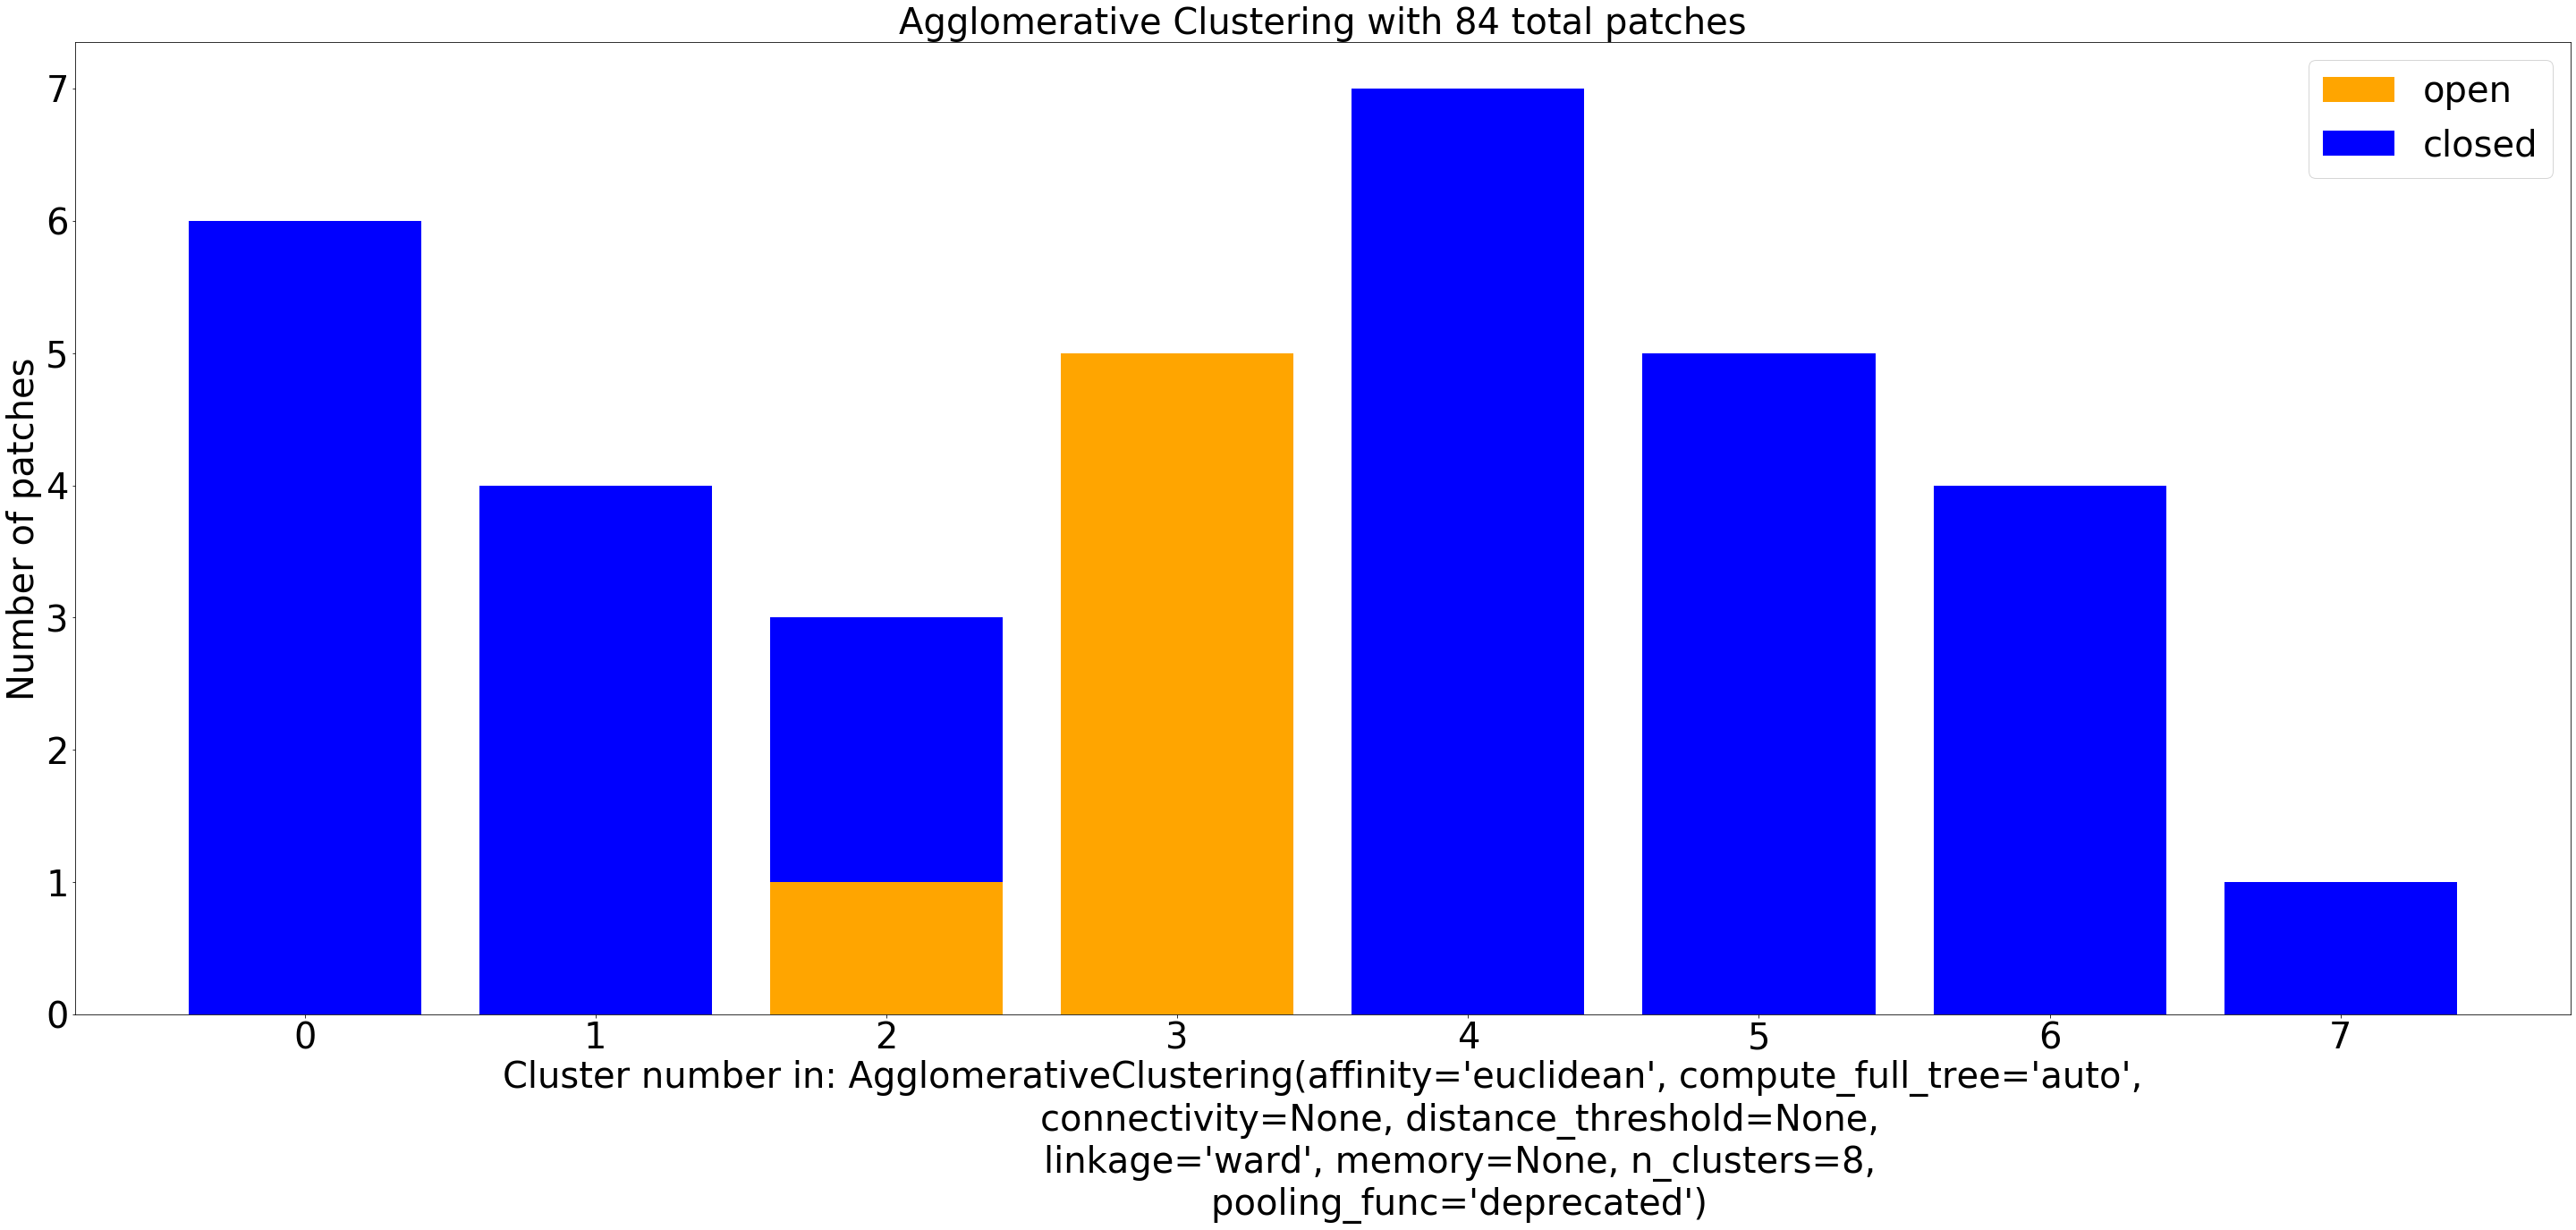

In [832]:
#create stacked bar graph 

from matplotlib import rc
import pandas as pd

plt.figure(figsize=(50,20))


# Heights of bars
bars = [len(open_clusters1), len(closed_clusters1)]

# The position of the bars on the x-axis
r = range(num_clusters)

# Label for each bar and bar width
x_labels = [str(i) for i in r]
barWidth = .8

# Create open-classified bars
plt.bar(r, open_clusters1, color='orange', width=barWidth)

# Stack bars
plt.bar(r, closed_clusters1, bottom=open_clusters1, color='blue', width=barWidth)

# label/title graph
plt.xticks(r, x_labels, fontsize=40)
plt.yticks(fontsize=40)
plt.ylabel("Number of patches", fontsize=40)
plt.xlabel("Cluster number in: "+ str(clustering), fontsize=40)
plt.legend(loc="upper right")
plt.legend(('open','closed'), fontsize=40)
plt.title("Agglomerative Clustering with %s total patches"%(len(label)), fontsize=40)
plt.show()

In [848]:
df1["cleaned open"] = open_clusters1
df1["cleaned closed"] = closed_clusters1
df1["cleaned % open"] = (df1["cleaned open"] / (df1["cleaned open"] + df1["cleaned closed"]))*100
df1["cleaned % closed"] = (df1["cleaned closed"] / (df1["cleaned open"] + df1["cleaned closed"]))*100
df1

,open,closed,% open,% closed,cleaned open,cleaned closed,cleaned % open,cleaned % closed
0,0,13,0.000000,100.000000,0,6,0.000000,100.000000
1,15,2,88.235294,11.764706,0,4,0.000000,100.000000
2,0,19,0.000000,100.000000,1,2,33.333333,66.666667
3,0,5,0.000000,100.000000,5,0,100.000000,0.000000
4,0,6,0.000000,100.000000,0,7,0.000000,100.000000
5,0,5,0.000000,100.000000,0,5,0.000000,100.000000
6,0,11,0.000000,100.000000,0,4,0.000000,100.000000
7,8,0,100.000000,0.000000,0,1,0.000000,100.000000


# Stuff

In [505]:
# visualize std for each band for each cluster
n_groups = 6

def get_cluster_means(list_clusters, i):
    return list_clusters[i].means

def get_cluster_std(list_clusters, i):
    return list_clusters[i].std

<Figure size 1440x216 with 0 Axes>

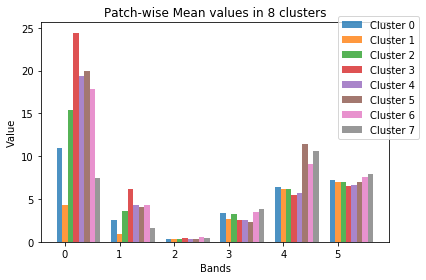

In [506]:
# create plot
f = plt.figure(figsize=(20,3))

fig, ax = plt.subplots()
index = 10*np.arange(n_groups)
bar_width = 1
opacity = 0.8


for i in range(num_clusters):
    plt.bar(index + bar_width*i, get_cluster_means(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

plt.xlabel('Bands')
plt.ylabel('Value')
plt.title('Patch-wise Mean values in %d clusters'%num_clusters)
plt.xticks(index + bar_width, range(6))
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()

<Figure size 1440x216 with 0 Axes>

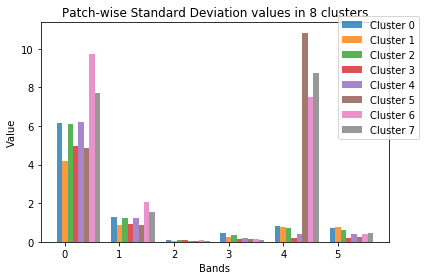

In [507]:
# visualize std for each band for each cluster
n_groups = 6

# create plot
f = plt.figure(figsize=(20,3))

fig, ax = plt.subplots()
index = 10*np.arange(n_groups)
bar_width = 1
opacity = 0.8

#make bars for each cluster
for i in range(num_clusters):
    plt.bar(index + bar_width*i, get_cluster_std(list_clusters,i), bar_width, 
            alpha=opacity,
            label='Cluster %d'%(i))

#set axes
plt.xlabel('Bands')
plt.ylabel('Value')
plt.title('Patch-wise Standard Deviation values in %d clusters'%num_clusters)
plt.xticks(index + bar_width, range(6))
plt.legend(loc=0)
plt.legend(bbox_to_anchor=(1.1, 1.05))


plt.tight_layout()
plt.show()

In [508]:
# N in [2, inf), you can change this number but save the result differently
def show_cluster_plot(num_clusters):
    clustering = AgglomerativeClustering(num_clusters)
    #turns any NAN values to 0 so code doesn't crash
    cleaned_features = np.nan_to_num(features)
    #generate clustering data
    label = clustering.fit_predict(cleaned_features)
    open_labels = label[:num_closed_features]
    closed_labels = label[num_closed_features:]
    #assign each patch instance its correct label
    for i in range(len(class_patch_list)):
        class_patch_list[i].label = label[i]
    #make a list of clusters
    list_clusters = [Cluster(label=i) for i in range(num_clusters)]
    #add patches to cluster objects
    for p in class_patch_list:
        matching_cluster = list_clusters[p.label]
        if p.isOpen:
            matching_cluster.num_open += 1
        if not matching_cluster.patches:
            matching_cluster.patches = [p]
        else:
            matching_cluster.patches.append(p)
    #add patch mean and std to cluster objects
    for c in list_clusters:
        c.means = get_band_means(c.patches)
        c.std = get_band_std(c.patches)
    #generate number of open and closed patches in each cluster
    open_clusters = [i.num_open for i in list_clusters]
    closed_clusters = [len(i.patches) - i.num_open for i in list_clusters]
    #create stacked bar graph 
    from matplotlib import rc
    import pandas as pd
    cloud_tsne = TSNE().fit_transform(cleaned_features)
    plot = cloud_scatter(cloud_tsne, label,num_clusters)
    plt.show()